# PDB Meta Data Demo

This demo shows how to query metadata from the PDB archive.

This exmaple queries the \_citation category. Each category represents a table, and fields represent database columns. [Avalible tables and columns](https://pdbj.org/mine-rdb-docs)

Example data from 100D.cif
 * _citation.id                        primary 
 * _citation.title                     Crystal structure of ...
 * _citation.journal_abbrev            'Nucleic Acids Res.' 
 * _citation.journal_volume            22 
 * _citation.page_first                5466 
 * _citation.page_last                 5476 
 * _citation.year                      1994 
 * _citation.journal_id_ASTM           NARHAD 
 * _citation.country                   UK 
 * _citation.journal_id_ISSN           0305-1048 
 * _citation.journal_id_CSD            0389 
 * _citation.book_publisher            ? 
 * _citation.pdbx_database_id_PubMed   7816639 
 * _citation.pdbx_database_id_DOI      10.1093/nar/22.24.5466 

Data are probided through [Mine 2 SQL](https://pdbj.org/help/mine2-sql)

Queries can be designed with the interactive [PDBj Mine 2 query service](https://pdbj.org/help/mine2-sql)

## Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from mmtfPyspark.datasets import pdbjMineDataset
import matplotlib.pyplot as plt

#### Configure Spark 

In [2]:
spark = SparkSession.builder.appName("PDBMetaDataDemo").getOrCreate()

2022-01-23 16:41:52 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Query PDBj Mine

Query the following fields from the \citation category using PDBj's Mine 2 web service:
 * journal_abbrev
 * pdbx_database_id_PubMed
 * year

Note: mixed case column names must be quoted and escaped with \


In [3]:
sqlQuery = "SELECT pdbid, journal_abbrev, \"pdbx_database_id_PubMed\", year from citation WHERE id = 'primary'"

ds = pdbjMineDataset.get_dataset(sqlQuery)

## Show first 10 results from query

In [4]:
ds.show(10, False)

+-----------+------------------+-----------------------+----+
|structureId|journal_abbrev    |pdbx_database_id_PubMed|year|
+-----------+------------------+-----------------------+----+
|101M       |Thesis, Rice      |-1                     |1999|
|100D       |Nucleic Acids Res.|7816639                |1994|
|101D       |Biochemistry      |7711020                |1995|
|107D       |J.Mol.Biol.       |7731041                |1995|
|107L       |Science           |8503008                |1993|
|108D       |Biochemistry      |7612596                |1995|
|107M       |Thesis, Rice      |-1                     |1999|
|108L       |Science           |8503008                |1993|
|102M       |Thesis, Rice      |-1                     |1999|
|102D       |J.Med.Chem.       |7608897                |1995|
+-----------+------------------+-----------------------+----+
only showing top 10 rows



## Filter out unpublished entries

Published entires contain the word "published" in various upper/lower case combinations

In [5]:
ds = ds.filter("UPPER(journal_abbrev) NOT LIKE '%PUBLISHED%'")

## Show the top 10 journals that publish PDB structures

In [6]:
ds.groupBy("journal_abbrev").count().sort(col("count").desc()).show(10,False)

[Stage 4:============================================>          (160 + 8) / 200]

+------------------------+-----+
|journal_abbrev          |count|
+------------------------+-----+
|J.Biol.Chem.            |11697|
|Biochemistry            |10756|
|J.Mol.Biol.             |10754|
|Proc.Natl.Acad.Sci.USA  |7143 |
|Structure               |6268 |
|Nat Commun              |6202 |
|J.Med.Chem.             |5959 |
|Nature                  |4418 |
|Acta Crystallogr.,Sect.D|4207 |
|Nucleic Acids Res.      |3172 |
+------------------------+-----+
only showing top 10 rows



## Filter out entries without a PubMed Id 

-1 if PubMed Id is not available

In [7]:
ds = ds.filter("pdbx_database_id_PubMed > 0")

print(f"Entires with PubMed Ids: {ds.count()}")

Entires with PubMed Ids: 153325


## Show growth of papers in PubMed

In [8]:
print("PubMed Ids per year: ")
idsPerYear = ds.groupBy("year").count().sort(col("year").desc())
idsPerYear.show(10, False)

PubMed Ids per year: 


[Stage 7:=============================>                             (1 + 1) / 2]

+----+-----+
|year|count|
+----+-----+
|2022|160  |
|2021|10024|
|2020|10909|
|2019|9599 |
|2018|9092 |
|2017|9363 |
|2016|9179 |
|2015|8437 |
|2014|7721 |
|2013|7773 |
+----+-----+
only showing top 10 rows



## Make scatter plot for growth of papers in PubMed

Text(0.5,1,'Growth of papers in PubMed each year')

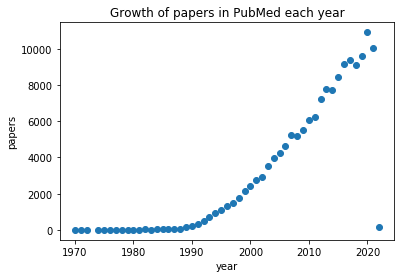

In [9]:
# Get year and publications as list
year = idsPerYear.select("year").collect()
publications = idsPerYear.select("count").collect()

# Make scatter plot with matplotlib
plt.scatter(year, publications)
plt.xlabel("year")
plt.ylabel("papers")
plt.title("Growth of papers in PubMed each year")

## Terminate Spark

In [10]:
spark.stop()